# **Project CVAE on MNIST datas**

In [1]:
# Imports
import random
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.nn.functional import triplet_margin_loss
from torch.nn.functional import pairwise_distance
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Loading Fashion-MNIST datasets
# Note: to improve speed we could save images as flatten images (using tranform for example)
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

## **Print random element of each class**

In [3]:
# Dictionary to map labels to class names
class_names = [
    'class 0: T-shirt/top', 'class 1: Trouser', 'class 2: Pullover', 'class 3: Dress', 'class 4: Coat',
    'class 5: Sandal', 'class 6: Shirt', 'class 7: Sneaker', 'class 8: Bag', 'class 9: Ankle boot'
]

def plot_random_samples_per_class(dataset):
    # Initialize a dictionary to store one sample per class
    samples = {i: None for i in range(10)}

    # Iterate through the dataset to select a random sample for each class
    for img, label in torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True):
        label = label.item()
        if samples[label] is None:  # Select the first sample found for each class
            samples[label] = img
        if all(v is not None for v in samples.values()):  # Stop once a sample for each class is found
            break

    # Create the figure with a 2x5 grid of subplots
    fig, axes = plt.subplots(2, 5, figsize=(12, 6))
    fig.suptitle("Random Sample from Each FashionMNIST Class")

    # Display each image in its corresponding subplot
    for i, (label, img) in enumerate(samples.items()):
        ax = axes[i // 5, i % 5]  # Position in the grid
        ax.imshow(img.squeeze(), cmap="gray")
        ax.set_title(class_names[label])
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust spacing
    plt.show()

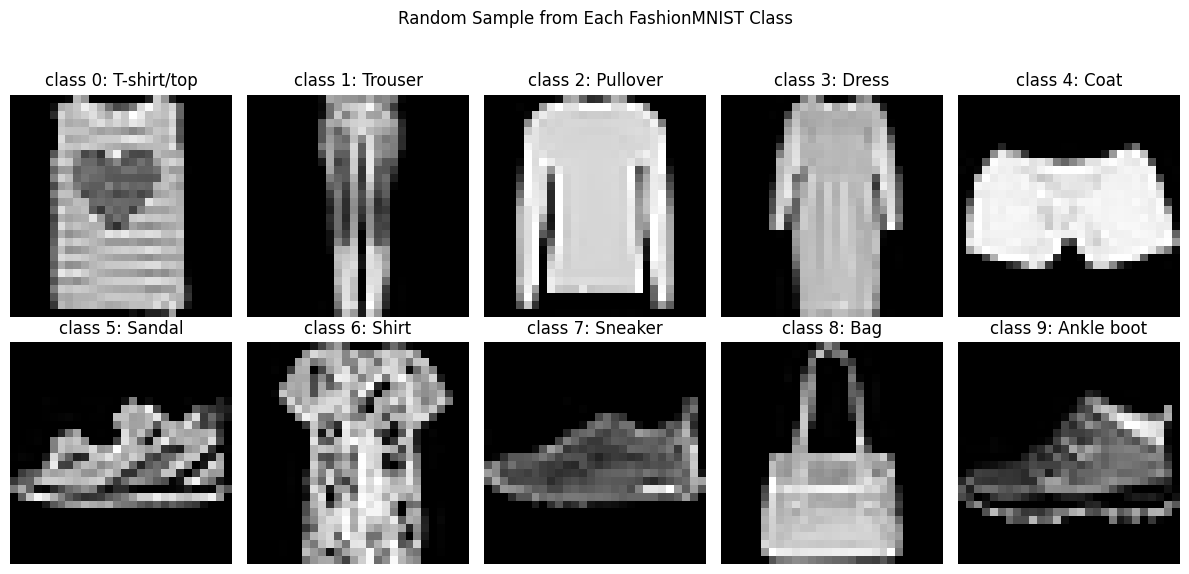

In [4]:
# Call function
plot_random_samples_per_class(train_dataset)

La classe 1 est différente des autres puisqu'il s'agit d'un pantalon (bas), aprés les classes.
En s'intéressant au contenu des classes, nous observons qu'une classe contient des vetements/chaussures/accessoires assez différents (forme assez variable), la variance intra classe est assez grande, cela explique le fait que les individus d'une même classe peuvent être assez éloigné 5 ( cluster pas très compact). La variance inter classe n'est pas non plus très grande puisque certains articles peuvent être similaires à d'autres. Cela peut impliquer une superposition d'individus de différentes classes ( ou overlapping).

## **Explanation between VAE and Conditional VAE (CVAE)**

Resources :
- https://proceedings.neurips.cc/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf
- https://arxiv.org/pdf/1312.6114
- https://lilianweng.github.io/posts/2018-08-12-vae/

In addition of the input data, the CVAE takes a conditional variable (a class label in our case) in input of both encoder and decoder. The goal of a CVAE is to shape the latent shape to correspond to the condition variable.

## **Hyperparameters**

In [5]:
# Global values
BATCH_SIZE = 64
MAX_EPOCHS = 10
LEARNING_RATE = 1e-3
CLASSES_TO_IDX = train_dataset.class_to_idx
IDX_TO_CLASSES = {idx: cls for cls, idx in CLASSES_TO_IDX.items()}
FEATURE_SIZE = train_dataset.data[0].shape[0]
CLASS_SIZE = 10
LATENT_SIZE = 100
NUM_CHANNELS = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


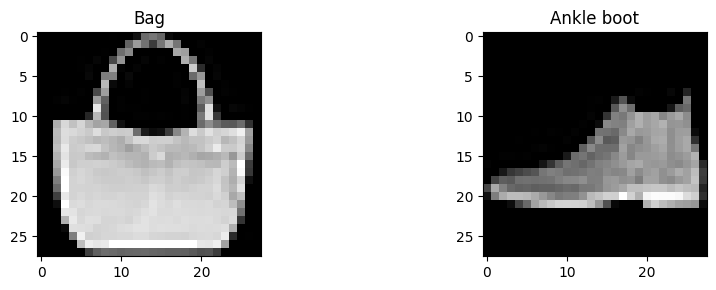

In [6]:
# Print the first image of each dataset
# Note: Do not run it after splitting datas into validation and test sets
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

axs[0].imshow(train_dataset.data[100], cmap='gray')
axs[0].set_title(f"{list(CLASSES_TO_IDX.keys())[train_dataset.targets[100]]}")

axs[1].imshow(test_dataset.data[0], cmap='gray')
axs[1].set_title(f"{list(CLASSES_TO_IDX.keys())[test_dataset.targets[0]]}")

plt.tight_layout()
plt.show()

In [7]:
# Split test between validation and test
val_size = int(test_dataset.data.shape[0] / 2)
test_size = test_dataset.data.shape[0] - val_size
test_dataset, val_dataset = random_split(test_dataset, [test_size, val_size])

# Some prints
print(f"Train dataset size: {len(train_dataset.data)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Makes dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Train dataset size: 60000
Validation dataset size: 5000
Test dataset size: 5000


## **Models used : Conditional Variational Auto-Encoders (CVAE)**

In [8]:
# See https://github.com/unnir/cVAE/blob/master/cvae.py
class CVAE(nn.Module):
    def __init__(self, feature_size=FEATURE_SIZE, num_classes=CLASS_SIZE, latent_size=LATENT_SIZE):
        super(CVAE, self).__init__()
        self.feature_size = feature_size

        # encode
        self.fc1  = nn.Linear(feature_size * feature_size + num_classes, 400)
        self.fc21 = nn.Linear(400, latent_size)
        self.fc22 = nn.Linear(400, latent_size)

        # decode
        self.fc3 = nn.Linear(latent_size + num_classes, 400)
        self.fc4 = nn.Linear(400, feature_size * feature_size)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

        # Center for each class in latent space
        self.class_centers = nn.Parameter(torch.randn(num_classes, latent_size))

    def encoder(self, x, c): # Q(z|x, c)
        inputs = torch.cat([x, c], 1)
        h1 = self.elu(self.fc1(inputs))
        z_mu = self.fc21(h1)
        z_var = self.fc22(h1)
        return z_mu, z_var

    def sample(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decoder(self, z, c): # P(x|z, c)
        inputs = torch.cat([z, c], 1)
        h3 = self.elu(self.fc3(inputs))
        recon = self.sigmoid(self.fc4(h3))
        return recon.view(inputs.size(0), 1, self.feature_size, self.feature_size)

    def forward(self, x, c):
        x = x.view(x.size(0), -1)
        mu, logvar = self.encoder(x, c)
        z = self.sample(mu, logvar)
        return self.decoder(z, c), z, mu, logvar

In [9]:
# References: https://hackaday.io/project/193478-generative-ai-on-a-microcontroller/log/225058-conditional-variational-autoencoder-cvae
class ConvCVAE(nn.Module):
    def __init__(self, num_channels=NUM_CHANNELS, feature_size=FEATURE_SIZE, num_classes=CLASS_SIZE, latent_size=LATENT_SIZE, dim1=32, dim2=64, dim3=128, dim4=256):
        super(ConvCVAE, self).__init__()
        self.feature_size = feature_size
        self.num_classes = num_classes
        self.dim4 = dim4

        # Encoder
        self.encoderseq = nn.Sequential(
            nn.Conv2d(num_channels + num_classes, dim1, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(dim1, dim2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(dim2, dim3, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(dim3, dim3, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )

        # Latent space
        self.fc_mu = nn.Linear(dim3 * 4 * 4 + num_classes, latent_size)
        self.fc_var = nn.Linear(dim3 * 4 * 4 + num_classes, latent_size)
        self.fc_decode1 = nn.Linear(latent_size + num_classes, dim4 * 4 * 4)

        # Decoder
        self.decoderseq = nn.Sequential(
            nn.ConvTranspose2d(dim4, dim3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(dim3, dim2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(dim2, dim1, kernel_size=3, stride=1, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(dim1, num_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

        self.last_activ = nn.Sigmoid()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decoder(self, z, labels):
        z = torch.cat((z, labels), dim=1)
        z = self.fc_decode1(z)
        z = F.relu(z)
        z = z.view(-1, self.dim4, 4, 4)
        z = self.decoderseq(z)
        z = F.interpolate(z, size=(self.feature_size, self.feature_size), mode='bicubic', align_corners=False) # To match the feature_size
        return self.last_activ(z)

    def forward(self, x, labels):
        labels_expanded = labels.view(-1, self.num_classes, 1, 1).expand(-1, -1, self.feature_size, self.feature_size)
        x = torch.cat((x, labels_expanded), dim=1)
        h = self.encoderseq(x)
        h = h.view(h.shape[0], -1)  # Flatten for fully connected layers
        h = torch.cat((h, labels), dim=1)
        mu, logvar = self.fc_mu(h), self.fc_var(h)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z, labels), z, mu, logvar


In [10]:
# Another architecture
class Encoder(nn.Module):
    def __init__(self, num_channels=NUM_CHANNELS, num_classes=CLASS_SIZE, latent_size=LATENT_SIZE):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(num_channels, 32, kernel_size=4, stride=2, padding=1)  # 28x28 -> 14x14
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1)  # 14x14 -> 7x7
        self.fc_mu = nn.Linear(64 * 7 * 7 + num_classes, latent_size)
        self.fc_logvar = nn.Linear(64 * 7 * 7 + num_classes, latent_size)

    def forward(self, x, y):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = torch.cat([x, y], dim=1)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, num_channels=NUM_CHANNELS, num_classes=CLASS_SIZE, latent_size=LATENT_SIZE):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_size + num_classes, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)  # 7x7 -> 14x14
        self.deconv2 = nn.ConvTranspose2d(32, num_channels, kernel_size=4, stride=2, padding=1)  # 14x14 -> 28x28

    def forward(self, z, y):
        z = torch.cat([z, y], dim=1)
        x = F.relu(self.fc(z))
        x = x.view(x.size(0), 64, 7, 7)
        x = F.relu(self.deconv1(x))
        x = torch.sigmoid(self.deconv2(x))
        return x

class ConvCVAE2(nn.Module):
    def __init__(self, num_classes=CLASS_SIZE, latent_size=LATENT_SIZE):
        super(ConvCVAE2, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, y):
        mu, logvar = self.encoder(x, y)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder(z, y)
        return x_recon, z, mu, logvar

## **Losses**

In [11]:
# Cette perte fonctionne en choisissant trois exemples :
# Ancre : un point latent de la classe cible.
# Positif : un autre point latent de la même classe.
# Négatif : un point latent d'une classe différente.
# La triplet loss pousse l’ancre et le positif à se rapprocher, et l’ancre et le négatif à s'éloigner. Cela peut être plus efficace pour séparer les classes.

def triplet_loss(z, y, margin=1.0):
    # Étendre les labels pour comparer toutes les paires
    y = y.unsqueeze(1)
    matches = (y == y.T)  # Matrice 1 si même classe, 0 sinon
    
    # Calcul des distances par paires
    pairwise_distances = torch.cdist(z, z, p=2)
    
    # Ancre-positif (AP) : Paires où matches == True
    positive_mask = matches.float()
    positive_distances = pairwise_distances * positive_mask  # Distances ancre-positif
    positive_distances[positive_mask == 0] = float('inf')  # Ignorer les non-positifs
    
    # Ancre-négatif (AN) : Paires où matches == False
    negative_mask = (~matches).float()
    negative_distances = pairwise_distances * negative_mask  # Distances ancre-négatif
    negative_distances[negative_mask == 0] = float('inf')  # Ignorer les non-négatifs
    
    # Trouver le positif le plus proche et le négatif le plus éloigné
    hardest_positive_dist = positive_distances.min(dim=1)[0]  # Positif le plus proche
    hardest_negative_dist = negative_distances.min(dim=1)[0]  # Négatif le plus éloigné
    
    # Calcul de la triplet loss
    loss = F.relu(hardest_positive_dist - hardest_negative_dist + margin).mean()
    return loss

In [12]:
def contrastive_loss(z, y, margin=1.0):
    # Calculer les distances par paires
    pairwise_distances = torch.cdist(z, z, p=2)  # Matrice des distances
    
    # Étendre y pour comparer toutes les paires
    y = y.unsqueeze(1)
    matches = (y == y.T).float()  # Matrice 1 si même classe, 0 sinon
    
    # Calcul de la perte
    positive_loss = matches * (pairwise_distances ** 2)
    negative_loss = (1 - matches) * torch.clamp(margin - pairwise_distances, min=0) ** 2
    
    # Moyenne sur toutes les paires
    loss = (positive_loss + negative_loss).mean()
    return loss

In [13]:
def total_loss(recon_x, x, mu, logvar, z, y, beta=1.0, alpha_tripl=1.0, alpha_contrast=1.0, add_contrastive=False, add_triplet=False):
    # Different losses used
    recon_loss = F.mse_loss(recon_x, x, reduction='sum') / x.size(0)
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    total_loss = recon_loss + beta * kld_loss

    if add_contrastive:
        contrast_loss = contrastive_loss(z, y)
        total_loss += alpha_contrast * contrast_loss

    if add_triplet:
        tripl_loss = triplet_loss(z, y)
        total_loss += alpha_tripl * tripl_loss
    
    return total_loss

## **Useful functions**

In [14]:
def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets.to(DEVICE)

In [15]:
def get_lr(optimizer):
    return optimizer.param_groups[0]['lr']

## **Training part**

In [16]:
def train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    device=DEVICE,
    scheduler=None,
    max_epochs=MAX_EPOCHS,
    num_classes=CLASS_SIZE,
    save_model=False,
    save_path="cvae_weights.pt"
):
    model = model.to(device)
    train_loss_l = torch.zeros(max_epochs)
    val_loss_l = torch.zeros(max_epochs)

    for epoch in range(1, max_epochs + 1):
        # ** Training **
        model.train()
        running_train_loss = 0.0
        for data, labels in tqdm(train_loader, desc=f"Epoch {epoch}/{max_epochs} Training"):
            data, labels = data.to(device), labels.to(device)
            if num_classes is not None:
                labels_one_hot = one_hot(labels, num_classes)

            # Forward pass
            optimizer.zero_grad()
            recon_data, z, mu, logvar = model(data, labels_one_hot)

            # Loss computation
            loss = total_loss(recon_data, data, mu, logvar, z, labels, beta=1.0, 
                              alpha_contrast=1.0, add_contrastive=True, alpha_tripl=1.0, add_triplet=True)

            # Backward pass and update weights
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()
        train_loss = running_train_loss / len(train_loader)

        # ** Validation **
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for data, labels in tqdm(val_loader, desc=f"Epoch {epoch}/{max_epochs} Validation"):
                data, labels = data.to(device), labels.to(device)
                if num_classes is not None:
                    labels_one_hot = one_hot(labels, num_classes)

                # Forward pass
                recon_data, z, mu, logvar = model(data, labels_one_hot)
                
                loss = total_loss(recon_data, data, mu, logvar, z, labels, beta=1.0,
                                  alpha_contrast=1.0, add_contrastive=True, alpha_tripl=1.0, add_triplet=True)
                running_val_loss += loss.item()
        val_loss = running_val_loss / len(val_loader)

        # Saving Losses
        train_loss_l[epoch - 1] = train_loss
        val_loss_l[epoch - 1] = val_loss

        # Print losses
        print(f"Epoch {epoch}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Update LR
        if scheduler:
            print(f"Learning Rate: {get_lr(optimizer):.6f}")
            scheduler.step()

    # Save trained model
    if save_model:
        torch.save(model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    return train_loss_l, val_loss_l

Epoch 1/12 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 90.88it/s]


Epoch 1, Training Loss: 53.7331, Validation Loss: 44.7693


Epoch 2/12 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 82.68it/s]


Epoch 2, Training Loss: 43.6240, Validation Loss: 42.2460


Epoch 3/12 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.56it/s]


Epoch 3, Training Loss: 41.9329, Validation Loss: 41.1233


Epoch 4/12 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 87.53it/s]


Epoch 4, Training Loss: 41.0370, Validation Loss: 40.3544


Epoch 5/12 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 79.93it/s]


Epoch 5, Training Loss: 40.3006, Validation Loss: 39.7149


Epoch 6/12 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.14it/s]


Epoch 6, Training Loss: 39.9166, Validation Loss: 39.3171


Epoch 7/12 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.10it/s]


Epoch 7, Training Loss: 39.5707, Validation Loss: 39.2540


Epoch 8/12 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 85.42it/s]


Epoch 8, Training Loss: 39.2648, Validation Loss: 38.9753


Epoch 9/12 Validation: 100%|████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 86.72it/s]


Epoch 9, Training Loss: 39.1115, Validation Loss: 38.7313


Epoch 10/12 Validation: 100%|███████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 84.96it/s]


Epoch 10, Training Loss: 38.9939, Validation Loss: 38.6048


Epoch 11/12 Validation: 100%|███████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 80.90it/s]


Epoch 11, Training Loss: 38.7282, Validation Loss: 38.4196


Epoch 12/12 Validation: 100%|███████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 88.21it/s]


Epoch 12, Training Loss: 38.7697, Validation Loss: 38.2894
Model saved to cvae_weights.pt


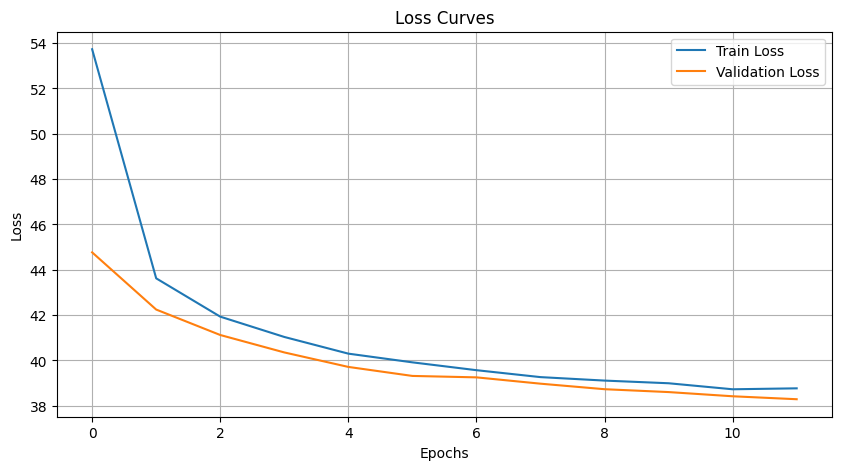

In [19]:
cvae = ConvCVAE2()
optimizer = torch.optim.Adam(cvae.parameters(), lr=LEARNING_RATE)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Call the train function
train_loss, val_loss = train_model(
    model=cvae,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=None, 
    save_model=True,
    max_epochs=12,
)

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## **Testing part**

In [20]:
def test_model(
    model,
    test_loader,
    device=DEVICE,
    num_classes=CLASS_SIZE,
    plot_latent_space=True,
    cmap="tab10",
    dim1_latent=0,
    dim2_latent=1,
):
    # Send model to device
    model = model.to(device)
    model.eval()

    running_test_loss = 0.0
    total_mse = 0.0
    residuals_sum = 0

    # Init plot
    if plot_latent_space:
        fig, ax = plt.subplots()
        scatter = ax.scatter([], [], c=[], cmap=cmap, vmin=0, vmax=num_classes - 1)

    with torch.no_grad():
        for data, labels in tqdm(test_loader, desc="Testing..."):
            data, labels = data.to(device), labels.to(device)
            if num_classes is not None:
                labels_one_hot = one_hot(labels, num_classes)

            # Forward pass
            recon_data, z, mu, logvar = model(data, labels_one_hot)
            loss = total_loss(recon_data, data, mu, logvar, z, labels, beta=1.0, alpha_contrast=2.0, add_contrastive=True)

            # Mean Squared Error
            mse_value = F.mse_loss(recon_data, data, reduction='sum')
            total_mse += mse_value.item()
            residuals_sum += torch.abs(data - recon_data).sum(dim=0)

            running_test_loss += loss.item()

            # Update plot
            if plot_latent_space:
                mu, labels = mu.cpu(), labels.cpu()
                scatter = ax.scatter(
                    mu[:, dim1_latent], mu[:, dim2_latent], c=labels, cmap=cmap, vmin=0, vmax=num_classes - 1
                )

    # Compute means
    test_loss = running_test_loss / len(test_loader)
    mse = total_mse / len(test_loader.dataset)

    print(f"Test loss: {test_loss:.4f} -- MSE: {mse:.4f}")

    if plot_latent_space:
        plt.colorbar(scatter)
        plt.title("Latent Space")
        plt.show()

    return test_loss, mse, residuals_sum

Testing...: 100%|██████████████████████████████████████████████████████████████████| 5000/5000 [00:47<00:00, 105.75it/s]


Test loss: 25.1030 -- MSE: 16.0897


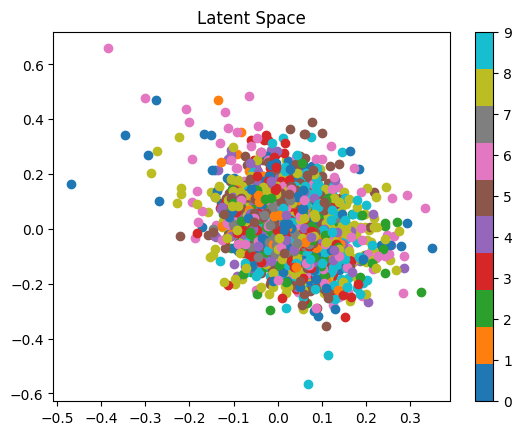

In [21]:
cvae = ConvCVAE2()
cvae.load_state_dict(torch.load("cvae_weights.pt", weights_only=True))

# Call the test function
test_loss, mse, residuals_sum = test_model(
    model=cvae,
    test_loader=test_loader,
    dim1_latent=0,
    dim2_latent=1,
)

In [22]:
# Makes some plots
def plot_test(
    model,
    test_loader,
    device=DEVICE,
    num_classes=CLASS_SIZE,
    classes=IDX_TO_CLASSES,
    batch_size=1,
    cmap="gray",
    figsize=(8, 8),
    num_samples=2
):
    model = model.to(device)
    model.eval()

    fig, axs = plt.subplots(nrows=num_samples, ncols=2, figsize=figsize)
    loader_iter = iter(test_loader)

    if num_samples > len(test_loader.dataset):
        print("Reduce the batch-size or the num_samples value!")
        return

    with torch.no_grad():
        for row in range(num_samples):
            data, labels = next(loader_iter)
            data, labels = data.to(device), labels.to(device)
            if num_classes is not None:
                labels_one_hot = one_hot(labels, num_classes)

            recon_data, _, _, _ = model(data, labels_one_hot)

            # Choose one sample in the batch
            if batch_size > 1:
                idx = random.randint(0, batch_size - 1)
            else:
                idx = 0

            # Move to CPU for plot
            original = data[idx].cpu().squeeze()
            reconstructed = recon_data[idx].cpu().detach().squeeze()
            label_idx = labels[idx] if num_classes else -1
            label_name = classes[label_idx.item()] if classes else f"Class {label_idx}"

            # Plot
            axs[row, 0].imshow(original, cmap=cmap)
            axs[row, 0].set_title(f"Original: {label_name}")
            axs[row, 0].axis("off")

            axs[row, 1].imshow(reconstructed, cmap=cmap)
            axs[row, 1].set_title("Reconstructed")
            axs[row, 1].axis("off")

    plt.tight_layout()
    plt.show()

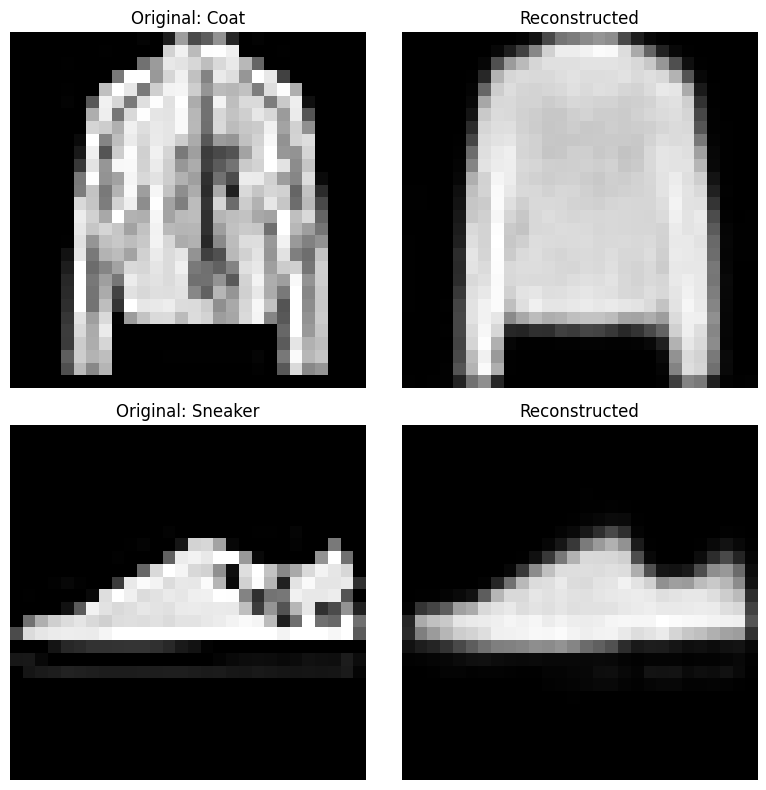

In [23]:
plot_test(cvae, test_loader)

## **Sampling**

In [24]:
def generate_and_plot_samples(model, num_samples=5, num_classes=CLASS_SIZE, latent_size=LATENT_SIZE, feature_size=FEATURE_SIZE, device=DEVICE):
    fig, axes = plt.subplots(num_classes, num_samples, figsize=(15, 10))
    fig.suptitle("Échantillons générés par classe")

    # Send model to device
    model = model.to(device)
    model.eval()

    for class_idx in range(num_classes):
        # Créer un vecteur one-hot pour la classe actuelle
        one_hot_class = one_hot(torch.tensor([class_idx]), num_classes)
        one_hot_class = one_hot_class.repeat(num_samples, 1)  # Répéter pour chaque échantillon

        # Générer des échantillons aléatoires dans l'espace latent
        z = torch.randn(num_samples, latent_size, device=device)

        # Générer des images à partir de chaque échantillon latent
        with torch.no_grad():
            generated_images = model.decoder(z, one_hot_class)

        # Afficher chaque image générée dans un sous-graphe
        for i in range(num_samples):
            ax = axes[class_idx, i]
            ax.imshow(generated_images[i].squeeze().cpu(), cmap="gray")
            ax.axis("off")
            if i == 0:
                ax.set_ylabel(f"Classe {class_idx}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

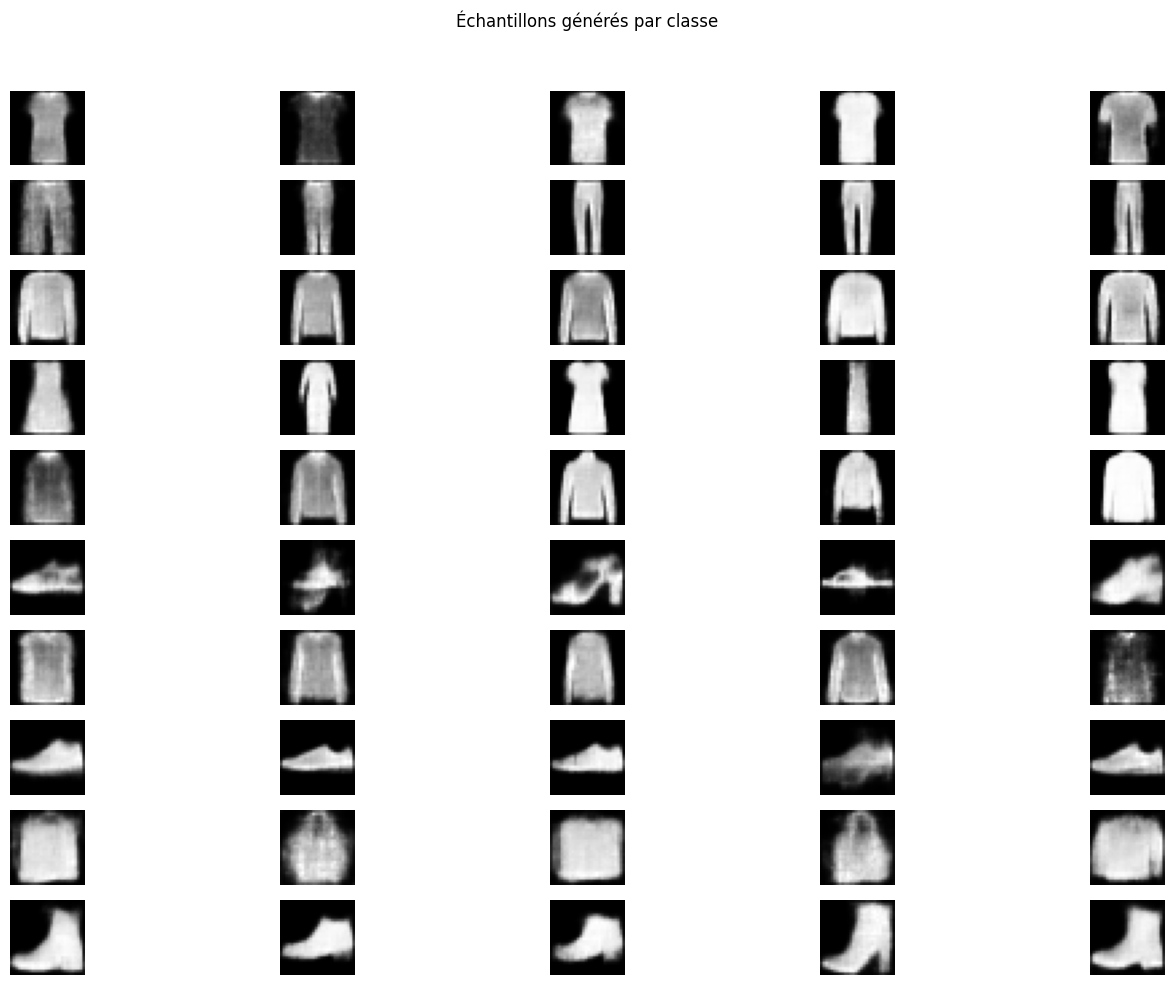

In [25]:
generate_and_plot_samples(cvae)